# Fraud Detection Model

**Business Purpose:** The goal of this model is to proactively detect fraudulent transactions. The model aims to predict which transactions are likely fraudulent so that the financial company can take actionable steps. Additionally, the model helps to identify key factors that contribute to fraud and informs updates to the company’s infrastructure.

## Notebook Outline:
1. Data Loading and Initial Exploration
2. Data Cleaning (Missing Values, Outliers, Multicollinearity)
3. Feature Engineering & Selection
4. Model Building (Logistic Regression & Random Forest)
5. Model Evaluation
6. Model Interpretation using SHAP
7. Actionable Insights

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For data splitting, scaling, and modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# For handling multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For model interpretation
import shap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

## 1. Data Loading and Initial Exploration

Adjust the file path as needed. In this example, we load a sample of the dataset to ease memory constraints.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to your CSV file - adjust this as necessary.
file_path = '/content/drive/MyDrive/Fraud.csv'

# For initial development, we use a sample (set sample_rows=None for full dataset)
sample_rows = None
if sample_rows:
    data = pd.read_csv(file_path, nrows=sample_rows)
else:
    data = pd.read_csv(file_path)

print("Data shape:", data.shape)
data.head()

Data shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 2. Data Cleaning

### 2.1 Missing Values
Check and impute missing values.

In [ ]:
print("Missing values per column:")
print(data.isnull().sum())

# Impute missing values:
# For numeric columns: fill missing values with the median.
# For categorical columns: fill missing values with the mode.
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].fillna(data[col].mode()[0])
    else:
        data[col] = data[col].fillna(data[col].median())

print("\nMissing values after imputation:")
print(data.isnull().sum())

Missing values per column:
step              0
type              0
amount            1
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

Missing values after imputation:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


### 2.2 Outlier Detection & Treatment
Visualize numeric columns with boxplots and cap outliers at the 1st and 99th percentiles.

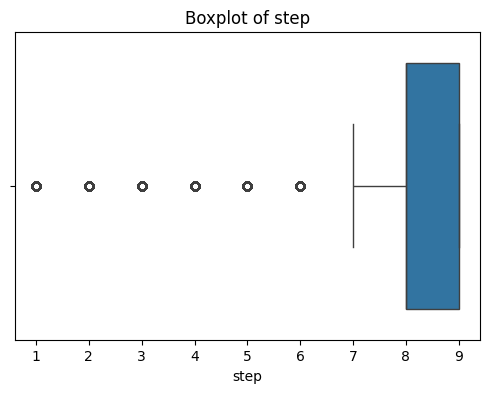

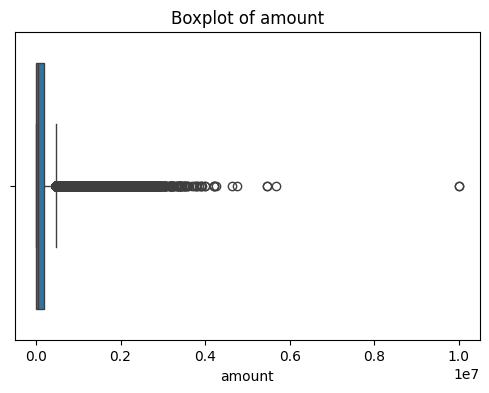

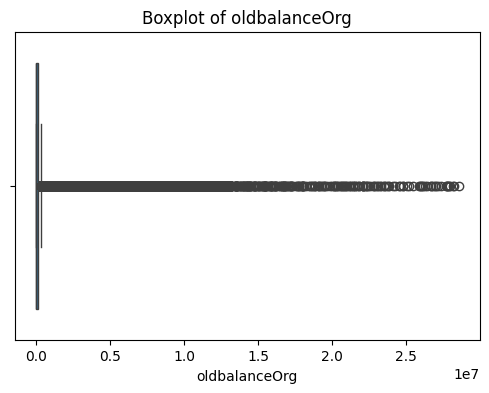

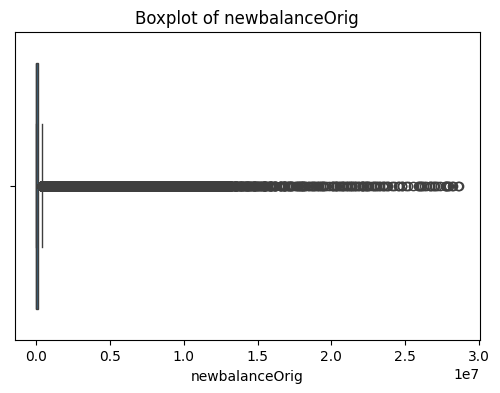

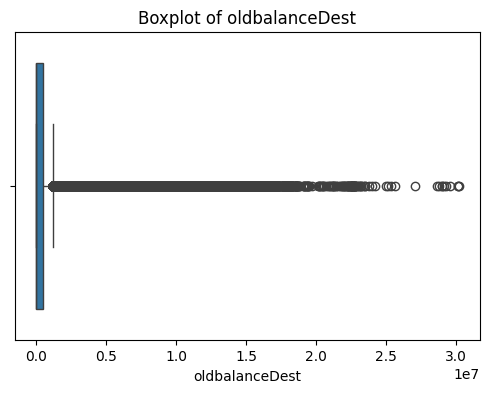

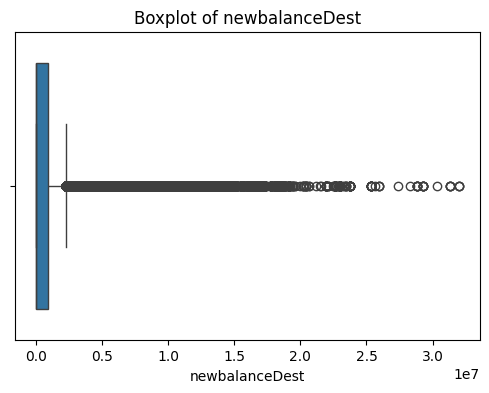

In [ ]:
# Identify numeric columns (excluding target variables if needed)
numeric_cols = [col for col in data.select_dtypes(include=[np.number]).columns if col not in ['isFraud', 'isFlaggedFraud']]

# Visualize distributions to detect outliers
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Cap outliers at 1st and 99th percentiles
for col in numeric_cols:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

### 2.3 Multicollinearity Check (VIF Calculation)
Remove highly collinear features if needed.

In [ ]:
features_for_vif = data[numeric_cols].copy()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = features_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(features_for_vif.values, i) for i in range(len(features_for_vif.columns))]
print(vif_data)

# If any features have a very high VIF (e.g., > 10), consider removing or combining them.
# For now, we proceed assuming no drastic multicollinearity issues.

          feature         VIF
0            step    1.442091
1          amount    1.729934
2   oldbalanceOrg  284.923314
3  newbalanceOrig  285.577743
4  oldbalanceDest    9.238566
5  newbalanceDest   10.456319


## 3. Feature Engineering & Selection

- **Encoding Categorical Variables:** Convert categorical columns to numeric.
- **Feature Selection:** Use domain knowledge, correlation analysis, or model-based methods to select key features.

Here we perform a simple encoding for the `'type'` column.

In [ ]:
# Encode categorical variable 'type' if it exists
if 'type' in data.columns:
    le = LabelEncoder()
    data['type_enc'] = le.fit_transform(data['type'])

# Optionally, drop original non-numeric identifiers if they are not useful for the model
data.drop(columns=['nameOrig', 'nameDest'], inplace=True, errors='ignore')

# Define the features and target variable (assuming 'isFraud' is the target)
target = 'isFraud'
features = [col for col in data.columns if col not in [target, 'isFlaggedFraud', 'type']]

print("Features used in the model:")
print(features)

Features used in the model:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_enc']


## 4. Model Building

### 4.1 Train-Test Split and Scaling
Split the data into training and testing sets and scale the numeric features.

In [ ]:
# Split into training and validation sets (70-30 split)
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4.3 Random Forest Model
Train a Random Forest model with GridSearchCV for hyperparameter tuning.

In [ ]:
# Random Forest with GridSearchCV
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Best ROC AUC (RF):", grid_rf.best_score_)

# Evaluate on test set
y_pred_rf = grid_rf.predict(X_test)
y_prob_rf = grid_rf.predict_proba(X_test)[:, 1]
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score (RF):", roc_auc_score(y_test, y_prob_rf))

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best ROC AUC (RF): 0.9981156904634432

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     16831
         1.0       0.93      0.43      0.59        30

    accuracy                           1.00     16861
   macro avg       0.96      0.72      0.80     16861
weighted avg       1.00      1.00      1.00     16861

ROC AUC Score (RF): 0.9903263818747154


## 5. Model Evaluation

Plot ROC curves for both models.

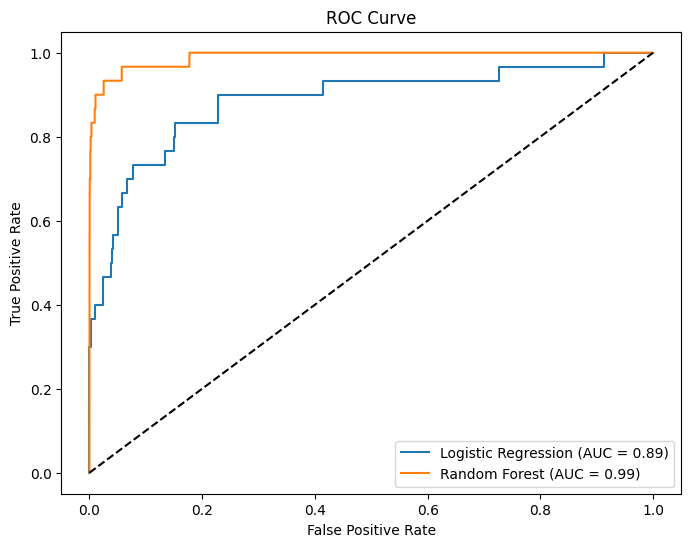

In [ ]:
# Plot ROC curves for both models
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For Logistic Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

print("Logistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression Confusion Matrix:")
print(cm_lr)
print("Logistic Regression Classification Report:")
print(report_lr)

# For Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Confusion Matrix:")
print(cm_rf)
print("Random Forest Classification Report:")
print(report_rf)


Logistic Regression Accuracy: 0.9985765968803748
Logistic Regression Confusion Matrix:
[[16831     0]
 [   24     6]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     16831
         1.0       1.00      0.20      0.33        30

    accuracy                           1.00     16861
   macro avg       1.00      0.60      0.67     16861
weighted avg       1.00      1.00      1.00     16861

Random Forest Accuracy: 0.9989324476602811
Random Forest Confusion Matrix:
[[16830     1]
 [   17    13]]
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     16831
         1.0       0.93      0.43      0.59        30

    accuracy                           1.00     16861
   macro avg       0.96      0.72      0.80     16861
weighted avg       1.00      1.00      1.00     16861



Checking new data point

In [ ]:
import pandas as pd

# --- New Data Point ---
# Original columns from your new datapoint:
# step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud
# Here, we ignore nameOrig, nameDest, isFraud, and isFlaggedFraud since they are not used for prediction.

# Create a DataFrame for the new data point
new_data = pd.DataFrame({
    'step': [1],
    'type': ['CASH_OUT'],
    'amount': [181],
    'oldbalanceOrg': [181],
    'newbalanceOrig': [0],
    'oldbalanceDest': [21182],
    'newbalanceDest': [0]
})

# --- Preprocessing ---
# 1. Encode the 'type' column (using the same encoder from training)
new_data['type_enc'] = le.transform(new_data['type'])

# 2. Drop columns that are not used for modeling (like 'type', nameOrig, nameDest, etc.)
# Here, we assume the model was trained with the following features:
features_model = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_enc']
new_data_model = new_data[features_model]

# --- Predictions ---
# For Logistic Regression, we need to scale the data using the scaler that was fit on the training data.
new_data_scaled = scaler.transform(new_data_model)

# Predict using Logistic Regression (grid_lr was the GridSearchCV object for LR)
pred_class_lr = grid_lr.predict(new_data_scaled)
pred_proba_lr = grid_lr.predict_proba(new_data_scaled)[:, 1]

# For Random Forest, use the unscaled data if that was your training process
pred_class_rf = grid_rf.predict(new_data_model)
pred_proba_rf = grid_rf.predict_proba(new_data_model)[:, 1]

# --- Output the Predictions ---
print("Logistic Regression Prediction:")
print("  Predicted Class:", pred_class_lr[0])
print("  Fraud Probability:", pred_proba_lr[0])

print("\nRandom Forest Prediction:")
print("  Predicted Class:", pred_class_rf[0])
print("  Fraud Probability:", pred_proba_rf[0])


Logistic Regression Prediction:
  Predicted Class: 0.0
  Fraud Probability: 0.058937496756151536

Random Forest Prediction:
  Predicted Class: 0.0
  Fraud Probability: 0.27467482404317195
